In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from PIL import Image
from tqdm import tqdm

# Set seeds for reproducibility
torch.manual_seed(39)
np.random.seed(39)

# Define dataset paths
FACE_DIR = "/kaggle/input/visa-multimodal/VISA_Face"
IRIS_DIR = "/kaggle/input/visa-multimodal/VISA_Iris/VISA_Iris"


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


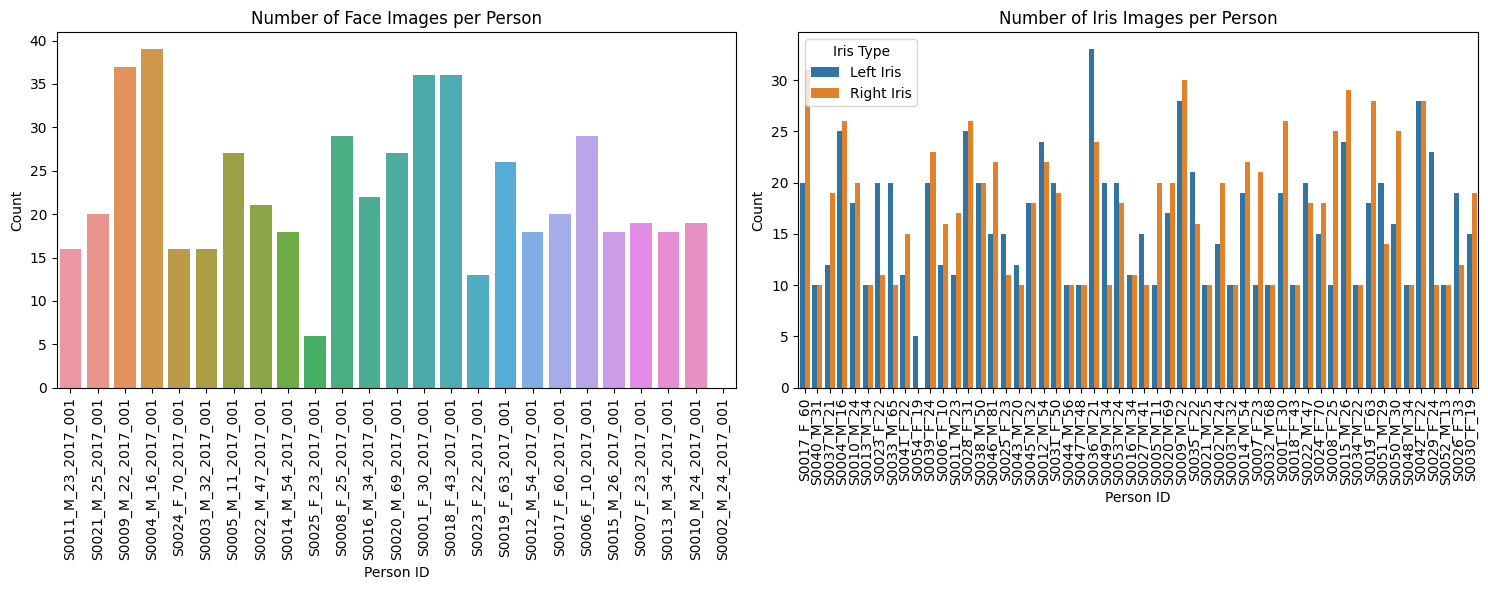

In [2]:
def explore_dataset(face_dir, iris_dir):
    """Explore and visualize the dataset structure"""
    # Count face images per person
    face_counts = {}
    for person in os.listdir(face_dir):
        person_path = os.path.join(face_dir, person)
        if os.path.isdir(person_path):
            face_counts[person] = len([f for f in os.listdir(person_path) if f.endswith('.jpg')])
    
    # Count iris images per person
    iris_counts = {'left': {}, 'right': {}}
    all_persons = set()
    
    # First pass to collect all unique persons
    for person in os.listdir(iris_dir):
        person_path = os.path.join(iris_dir, person)
        if os.path.isdir(person_path):
            all_persons.add(person)
            
    # Second pass to count images
    for person in all_persons:
        person_path = os.path.join(iris_dir, person)
        left_path = os.path.join(person_path, 'L')
        right_path = os.path.join(person_path, 'R')
        
        iris_counts['left'][person] = len([f for f in os.listdir(left_path) if f.endswith('.bmp')]) if os.path.exists(left_path) else 0
        iris_counts['right'][person] = len([f for f in os.listdir(right_path) if f.endswith('.bmp')]) if os.path.exists(right_path) else 0

    # Create aligned data structure
    persons = list(all_persons)
    left_counts = [iris_counts['left'].get(p, 0) for p in persons]
    right_counts = [iris_counts['right'].get(p, 0) for p in persons]

    # Visualize the dataset distribution
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    sns.barplot(x=list(face_counts.keys()), y=list(face_counts.values()))
    plt.title('Number of Face Images per Person')
    plt.xticks(rotation=90)
    plt.xlabel('Person ID')
    plt.ylabel('Count')
    
    plt.subplot(1, 2, 2)
    df = pd.DataFrame({
        'Person': persons,
        'Left Iris': left_counts,
        'Right Iris': right_counts
    })
    df_melted = df.melt(id_vars='Person', var_name='Iris Type', value_name='Count')
    sns.barplot(x='Person', y='Count', hue='Iris Type', data=df_melted)
    plt.title('Number of Iris Images per Person')
    plt.xticks(rotation=90)
    plt.xlabel('Person ID')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    return face_counts, iris_counts

# Run the exploration
face_counts, iris_counts = explore_dataset(FACE_DIR, IRIS_DIR)


In [3]:
class BiometricDataset(Dataset):
    def __init__(self, face_dir, iris_dir, split='train', test_size=0.15, val_size=0.15, transform=None, use_both_eyes=True):
        self.face_dir = face_dir
        self.iris_dir = iris_dir
        self.transform = transform
        self.split = split
        self.use_both_eyes = use_both_eyes
        
        # Store person data
        self.person_data = {}
        for person in os.listdir(face_dir):
            person_path = os.path.join(face_dir, person)
            if os.path.isdir(person_path):
                person_id = person[:10]
                iris_path = os.path.join(iris_dir, person_id)
                if os.path.exists(iris_path):
                    face_imgs = [os.path.join(person_path, img) for img in os.listdir(person_path) if img.endswith(".jpg")]
                    left_iris = [os.path.join(iris_path, "L", img) for img in os.listdir(os.path.join(iris_path, "L")) if img.endswith(".bmp")] if os.path.exists(os.path.join(iris_path, "L")) else []
                    right_iris = [os.path.join(iris_path, "R", img) for img in os.listdir(os.path.join(iris_path, "R")) if img.endswith(".bmp")] if os.path.exists(os.path.join(iris_path, "R")) else []
                    if face_imgs and (left_iris or right_iris):
                        self.person_data[person_id] = {'face': face_imgs, 'left': left_iris, 'right': right_iris}
        
        # Create pairs (genuine and impostor)
        self.pairs = []
        self.labels = []
        person_ids = list(self.person_data.keys())
        
        for i, pid1 in enumerate(person_ids):
            # Genuine pairs
            for face in self.person_data[pid1]['face']:
                for iris in self.person_data[pid1]['left'][:1]:  # Limit to one for balance
                    self.pairs.append((face, iris, 'left'))
                    self.labels.append(1)  # Genuine
                if self.use_both_eyes:
                    for iris in self.person_data[pid1]['right'][:1]:
                        self.pairs.append((face, iris, 'right'))
                        self.labels.append(1)  # Genuine
            # Impostor pairs
            pid2 = person_ids[(i + 1) % len(person_ids)]  # Next person for impostor
            for face in self.person_data[pid1]['face'][:1]:  # Limit for balance
                for iris in self.person_data[pid2]['left'][:1]:
                    self.pairs.append((face, iris, 'left'))
                    self.labels.append(0)  # Impostor
        
        # Split data
        indices = np.arange(len(self.pairs))
        train_idx, test_idx = train_test_split(indices, test_size=test_size, stratify=self.labels, random_state=42)
        if val_size > 0:
            train_idx, val_idx = train_test_split(train_idx, test_size=val_size/(1-test_size), stratify=[self.labels[i] for i in train_idx], random_state=42)
        else:
            val_idx = []
        
        self.indices = {'train': train_idx, 'val': val_idx, 'test': test_idx}.get(split, indices)
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        idx = self.indices[idx]
        face_path, iris_path, eye_type = self.pairs[idx]
        label = self.labels[idx]
        
        face_img = Image.open(face_path).convert("RGB")
        iris_img = Image.open(iris_path).convert("L")
        
        if self.transform:
            face_img = self.transform(face_img)
            iris_img = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])
            ])(iris_img)
        
        return face_img, iris_img, label, eye_type

# Define image transformations
face_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = BiometricDataset(FACE_DIR, IRIS_DIR, split='train', transform=face_transform)
val_dataset = BiometricDataset(FACE_DIR, IRIS_DIR, split='val', transform=face_transform)
test_dataset = BiometricDataset(FACE_DIR, IRIS_DIR, split='test', transform=face_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)


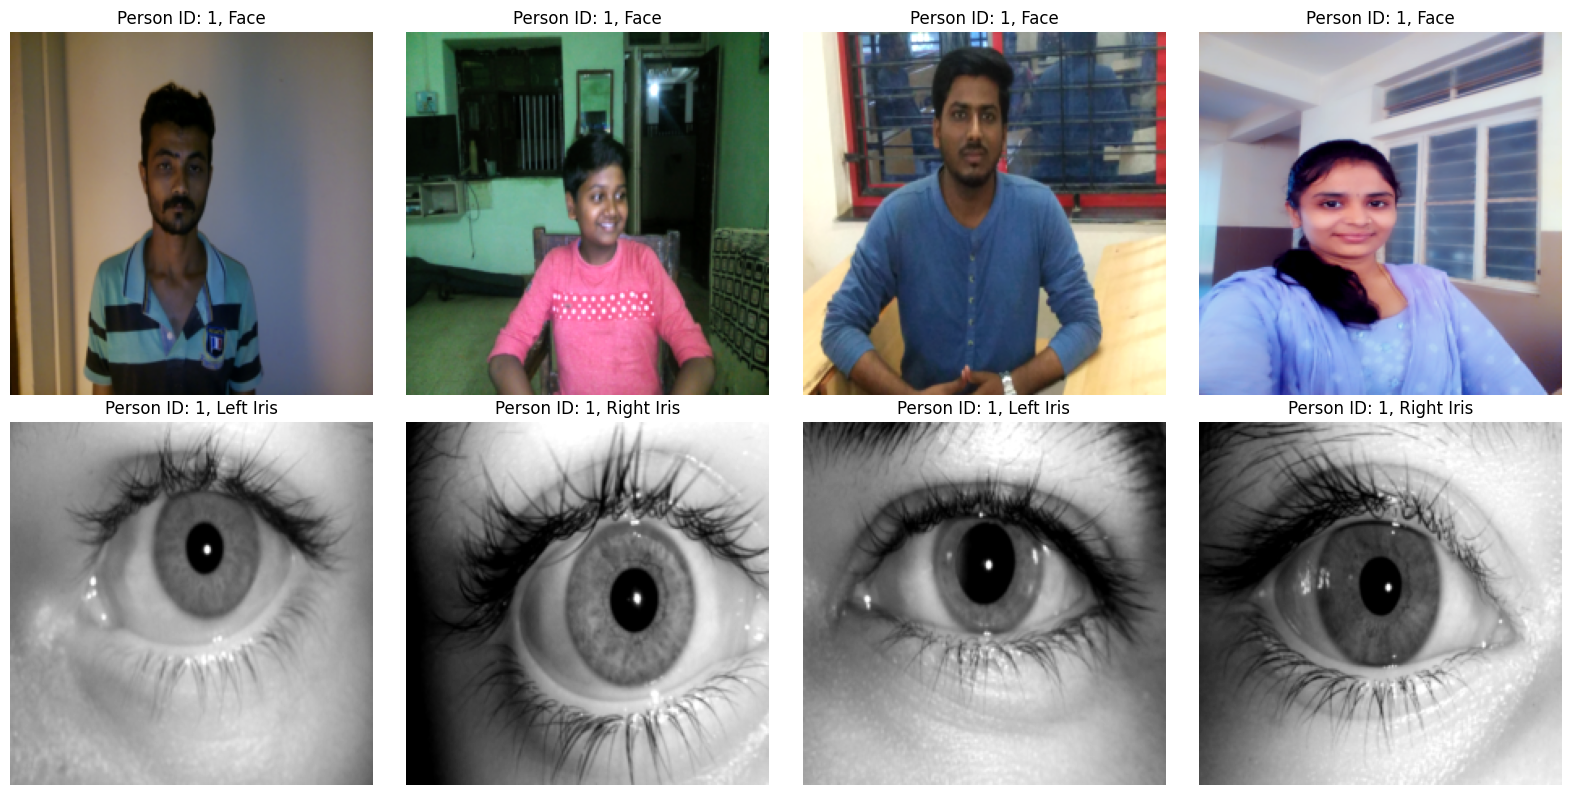

In [4]:
def visualize_batch(dataset, num_samples=4):
    """Visualize sample pairs from the dataset"""
    fig, axes = plt.subplots(2, num_samples, figsize=(16, 8))
    
    for i in range(num_samples):
        face_img, iris_img, label, eye_type = dataset[i]
        
        # Denormalize images for visualization
        face_img = face_img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        face_img = torch.clamp(face_img, 0, 1)
        
        iris_img = iris_img * 0.5 + 0.5  # Denormalize
        
        # Display images
        axes[0, i].imshow(face_img.permute(1, 2, 0).numpy())
        axes[0, i].set_title(f"Person ID: {label}, Face")
        axes[0, i].axis('off')
        
        axes[1, i].imshow(iris_img.squeeze(0).numpy(), cmap='gray')
        axes[1, i].set_title(f"Person ID: {label}, {eye_type.capitalize()} Iris")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_batch(train_dataset)


In [5]:
class FaceFeatureExtractor(nn.Module):
    """Feature extraction model for face images based on ResNet50"""
    def __init__(self, pretrained=True, feature_dim=512):
        super(FaceFeatureExtractor, self).__init__()
        # Using ResNet50 as base model as mentioned in research papers
        self.base_model = models.resnet50(pretrained=pretrained)
        # Replace the final FC layer
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, feature_dim)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        return self.base_model(x)

class IrisFeatureExtractor(nn.Module):
    """Feature extraction model for iris images based on VGG16"""
    def __init__(self, pretrained=True, feature_dim=512):
        super(IrisFeatureExtractor, self).__init__()
        # Using modified VGG16 for iris as mentioned in some papers
        self.base_model = models.vgg16(pretrained=pretrained)
        # Modify first layer to accept grayscale input
        self.base_model.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        # Replace classifier
        self.base_model.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, feature_dim)
        )
        
    def forward(self, x):
        return self.base_model(x)


In [6]:
class CrossAttentionFusion(nn.Module):
    """Cross-attention fusion module based on paper [5]"""
    def __init__(self, embed_dim=512, num_heads=8):
        super(CrossAttentionFusion, self).__init__()
        self.face_norm = nn.LayerNorm(embed_dim)
        self.iris_norm = nn.LayerNorm(embed_dim)
        
        # Multi-head attention layers
        self.face_to_iris_attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.iris_to_face_attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        
        # Feed-forward networks
        self.face_ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(embed_dim * 4, embed_dim),
            nn.Dropout(0.1)
        )
        
        self.iris_ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(embed_dim * 4, embed_dim),
            nn.Dropout(0.1)
        )
        
        # Final fusion layer
        self.fusion_layer = nn.Linear(embed_dim * 2, embed_dim)
        
    def forward(self, face_features, iris_features):
        # Reshape tensors to (batch_size, 1, embed_dim) for attention
        batch_size = face_features.size(0)
        face_features = face_features.view(batch_size, 1, -1)
        iris_features = iris_features.view(batch_size, 1, -1)
        
        # Apply layer normalization
        face_norm = self.face_norm(face_features)
        iris_norm = self.iris_norm(iris_features)
        
        # Cross-attention
        face_attended, _ = self.face_to_iris_attention(face_norm, iris_norm, iris_norm)
        iris_attended, _ = self.iris_to_face_attention(iris_norm, face_norm, face_norm)
        
        # Residual connection
        face_residual = face_features + face_attended
        iris_residual = iris_features + iris_attended
        
        # Feed-forward networks
        face_output = face_residual + self.face_ffn(face_residual)
        iris_output = iris_residual + self.iris_ffn(iris_residual)
        
        # Concatenate and fuse
        combined = torch.cat([face_output.squeeze(1), iris_output.squeeze(1)], dim=1)
        fused = self.fusion_layer(combined)
        
        return fused

class ScoreLevelFusion(nn.Module):
    """Score-level fusion with SVM-inspired approach (based on paper [1])"""
    def __init__(self, input_dim=1024, hidden_dim=512, output_dim=256):
        super(ScoreLevelFusion, self).__init__()
        # SVM-inspired layers (using neural network approximation)
        self.fusion_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(output_dim, output_dim),
        )
        
    def forward(self, face_scores, iris_scores):
        # Concatenate the scores from both modalities
        combined_scores = torch.cat([face_scores, iris_scores], dim=1)
        return self.fusion_layer(combined_scores)


In [7]:
class MultimodalBiometricSystem(nn.Module):
    def __init__(self, num_classes, fusion_type='cross_attention', feature_dim=512):
        super(MultimodalBiometricSystem, self).__init__()
        self.fusion_type = fusion_type
        
        # Feature extractors
        self.face_extractor = FaceFeatureExtractor(feature_dim=feature_dim)
        self.iris_extractor = IrisFeatureExtractor(feature_dim=feature_dim)
        
        # Fusion module
        if fusion_type == 'cross_attention':
            self.fusion_module = CrossAttentionFusion(embed_dim=feature_dim)
            self.classifier = nn.Sequential(
                nn.Linear(feature_dim, feature_dim),
                nn.ReLU(),
                nn.Dropout(0.5),  # Dropout added here
                nn.Linear(feature_dim, num_classes)
            )
        elif fusion_type == 'score_level':
            self.face_classifier = nn.Linear(feature_dim, feature_dim)
            self.iris_classifier = nn.Linear(feature_dim, feature_dim)
            self.fusion_module = ScoreLevelFusion(input_dim=feature_dim*2, output_dim=feature_dim)
            self.classifier = nn.Sequential(
                nn.Linear(feature_dim, feature_dim),
                nn.ReLU(),
                nn.Dropout(0.5),  # Dropout added here
                nn.Linear(feature_dim, num_classes)
            )

    def forward(self, face_input, iris_input):
        face_features = self.face_extractor(face_input)
        iris_features = self.iris_extractor(iris_input)

        if self.fusion_type == 'cross_attention':
            fused_features = self.fusion_module(face_features, iris_features)
            output = self.classifier(fused_features)
        elif self.fusion_type == 'score_level':
            face_scores = self.face_classifier(face_features)
            iris_scores = self.iris_classifier(iris_features)
            fused_scores = self.fusion_module(face_scores, iris_scores)
            output = self.classifier(fused_scores)

        return output

    
    def get_face_features(self, face_input):
        return self.face_extractor(face_input)
    
    def get_iris_features(self, iris_input):
        return self.iris_extractor(iris_input)


In [8]:
class FaceOnlyModel(nn.Module):
    """Face recognition only model"""
    def __init__(self, num_classes, feature_dim=512):
        super(FaceOnlyModel, self).__init__()
        self.face_extractor = FaceFeatureExtractor(feature_dim=feature_dim)
        self.classifier = nn.Linear(feature_dim, num_classes)
        
    def forward(self, face_input):
        face_features = self.face_extractor(face_input)
        return self.classifier(face_features)

class IrisOnlyModel(nn.Module):
    """Iris recognition only model"""
    def __init__(self, num_classes, feature_dim=512):
        super(IrisOnlyModel, self).__init__()
        self.iris_extractor = IrisFeatureExtractor(feature_dim=feature_dim)
        self.classifier = nn.Linear(feature_dim, num_classes)
        
    def forward(self, iris_input):
        iris_features = self.iris_extractor(iris_input)
        return self.classifier(iris_features)


In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, 
                num_epochs=25, device='cuda', model_type='multimodal'):
    """Train the model and return training history"""
    # Move model to device
    model = model.to(device)
    
    # Track best validation accuracy
    best_val_acc = 0.0
    
    # History for plotting
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0
        
        # Progress bar
        pbar = tqdm(train_loader, desc=f"Training epoch {epoch+1}/{num_epochs}")
        
        for inputs in pbar:
            if model_type == 'multimodal':
                face_inputs, iris_inputs, labels, _ = inputs
                face_inputs = face_inputs.to(device)
                iris_inputs = iris_inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(face_inputs, iris_inputs)
            elif model_type == 'face_only':
                face_inputs, _, labels, _ = inputs
                face_inputs = face_inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(face_inputs)
            elif model_type == 'iris_only':
                _, iris_inputs, labels, _ = inputs
                iris_inputs = iris_inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(iris_inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels).item()
            total_samples += labels.size(0)
            
            # Update progress bar
            pbar.set_postfix({'loss': loss.item(), 'acc': running_corrects/total_samples})
        
        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects / total_samples
        
        print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        
        # Validation phase
        if val_loader:
            model.eval()
            running_loss = 0.0
            running_corrects = 0
            total_samples = 0
            
            with torch.no_grad():
                for inputs in val_loader:
                    if model_type == 'multimodal':
                        face_inputs, iris_inputs, labels, _ = inputs
                        face_inputs = face_inputs.to(device)
                        iris_inputs = iris_inputs.to(device)
                        labels = labels.to(device)
                        
                        outputs = model(face_inputs, iris_inputs)
                    elif model_type == 'face_only':
                        face_inputs, _, labels, _ = inputs
                        face_inputs = face_inputs.to(device)
                        labels = labels.to(device)
                        
                        outputs = model(face_inputs)
                    elif model_type == 'iris_only':
                        _, iris_inputs, labels, _ = inputs
                        iris_inputs = iris_inputs.to(device)
                        labels = labels.to(device)
                        
                        outputs = model(iris_inputs)
                    
                    loss = criterion(outputs, labels)
                    
                    # Statistics
                    running_loss += loss.item() * labels.size(0)
                    _, preds = torch.max(outputs, 1)
                    running_corrects += torch.sum(preds == labels).item()
                    total_samples += labels.size(0)
            
            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects / total_samples
            
            print(f'Validation Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            history['val_loss'].append(epoch_loss)
            history['val_acc'].append(epoch_acc)
            
            # Update scheduler if provided
            if scheduler:
                scheduler.step(epoch_acc)
                
            # Save best model
            if epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                torch.save(model.state_dict(), f'best_{model_type}_model.pth')
    
    print(f'Best validation accuracy: {best_val_acc:.4f}')
    return history

def evaluate_model(model, test_loader, criterion, device='cuda', model_type='multimodal'):
    """Evaluate the model on the test set"""
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs in tqdm(test_loader, desc="Evaluating"):
            if model_type == 'multimodal':
                face_inputs, iris_inputs, labels, _ = inputs
                face_inputs = face_inputs.to(device)
                iris_inputs = iris_inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(face_inputs, iris_inputs)
            elif model_type == 'face_only':
                face_inputs, _, labels, _ = inputs
                face_inputs = face_inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(face_inputs)
            elif model_type == 'iris_only':
                _, iris_inputs, labels, _ = inputs
                iris_inputs = iris_inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(iris_inputs)
            
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels).item()
            total_samples += labels.size(0)
            
            # Store for confusion matrix
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    test_loss = running_loss / total_samples
    test_acc = running_corrects / total_samples
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
    print(f'Classification Report:')
    print(classification_report(all_labels, all_preds))
    
    return {
        'loss': test_loss,
        'accuracy': test_acc,
        'predictions': all_preds,
        'labels': all_labels,
        'confusion_matrix': cm
    }


In [13]:
# Define hyperparameters
num_classes = 2  # Binary classification (genuine vs impostor)
feature_dim = 512
learning_rate = 1e-4
num_epochs = 4

# Instantiate models
multimodal_model = MultimodalBiometricSystem(num_classes=num_classes, fusion_type='cross_attention', feature_dim=feature_dim)
face_only_model = FaceOnlyModel(num_classes=num_classes, feature_dim=feature_dim)
iris_only_model = IrisOnlyModel(num_classes=num_classes, feature_dim=feature_dim)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_multimodal = optim.Adam(multimodal_model.parameters(), lr=learning_rate)
optimizer_face = optim.Adam(face_only_model.parameters(), lr=learning_rate)
optimizer_iris = optim.Adam(iris_only_model.parameters(), lr=learning_rate)


In [14]:
import matplotlib.pyplot as plt

def plot_training_history(history, title='Training History'):
    """Plot training and validation loss and accuracy."""
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss', color='blue')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy', color='green')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy', color='red')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Add overall title and display
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


Epoch 1/4
----------


Training epoch 1/4: 100%|██████████| 49/49 [19:51<00:00, 24.32s/it, loss=0.00493, acc=0.978]

Training Loss: 0.1335 Acc: 0.9782


Validation Loss: 0.1153 Acc: 0.9821
Epoch 2/4
----------


Training epoch 2/4: 100%|██████████| 49/49 [20:11<00:00, 24.73s/it, loss=0.0134, acc=0.978] 

Training Loss: 0.1155 Acc: 0.9782


Validation Loss: 0.1119 Acc: 0.9821
Epoch 3/4
----------


Training epoch 3/4: 100%|██████████| 49/49 [19:45<00:00, 24.19s/it, loss=0.032, acc=0.978]  

Training Loss: 0.1026 Acc: 0.9782


Validation Loss: 0.1375 Acc: 0.9821
Epoch 4/4
----------


Training epoch 4/4: 100%|██████████| 49/49 [19:19<00:00, 23.65s/it, loss=0.00645, acc=0.978]

Training Loss: 0.0983 Acc: 0.9782


Validation Loss: 0.1377 Acc: 0.9821
Best validation accuracy: 0.9821


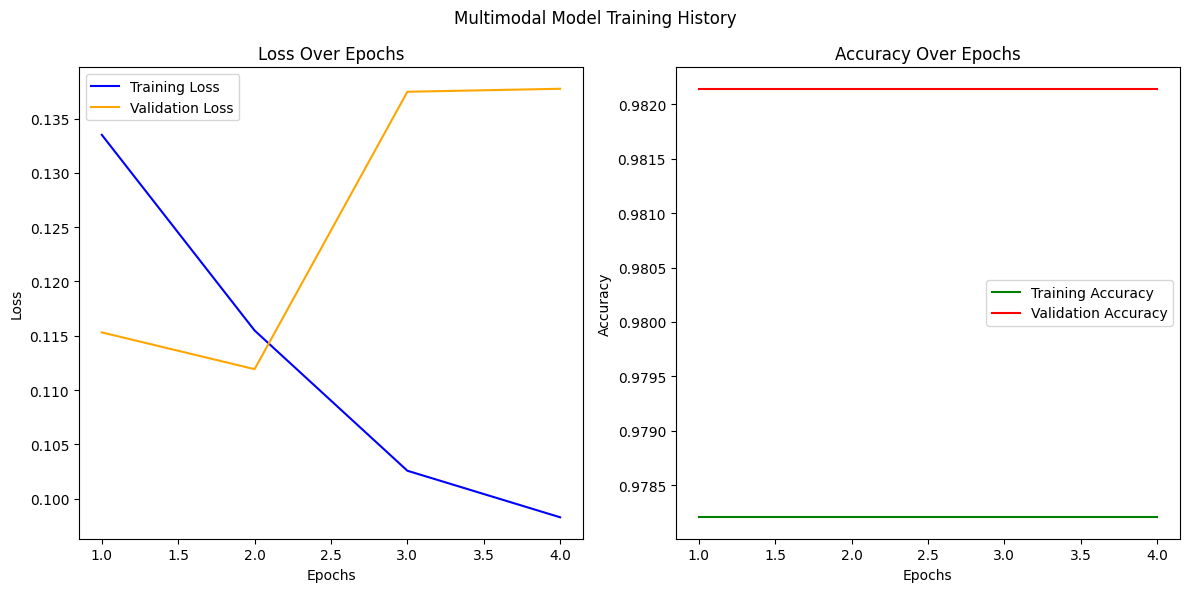

In [15]:
# Train multimodal model
history_multimodal = train_model(
    model=multimodal_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_multimodal,
    num_epochs=num_epochs,
    device='cpu',
    model_type='multimodal'
)

plot_training_history(history_multimodal, title="Multimodal Model Training History")


Epoch 1/4
----------


Training epoch 1/4: 100%|██████████| 49/49 [04:57<00:00,  6.07s/it, loss=0.00302, acc=0.965]

Training Loss: 0.1481 Acc: 0.9654


Validation Loss: 0.0962 Acc: 0.9821
Epoch 2/4
----------


Training epoch 2/4: 100%|██████████| 49/49 [04:59<00:00,  6.12s/it, loss=0.00774, acc=0.978]

Training Loss: 0.1140 Acc: 0.9782


Validation Loss: 0.1224 Acc: 0.9821
Epoch 3/4
----------


Training epoch 3/4: 100%|██████████| 49/49 [04:52<00:00,  5.96s/it, loss=0.0191, acc=0.978]

Training Loss: 0.0895 Acc: 0.9782


Validation Loss: 0.1544 Acc: 0.9821
Epoch 4/4
----------


Training epoch 4/4: 100%|██████████| 49/49 [04:52<00:00,  5.97s/it, loss=0.0248, acc=0.978] 

Training Loss: 0.0858 Acc: 0.9782


Validation Loss: 0.2072 Acc: 0.9821
Best validation accuracy: 0.9821


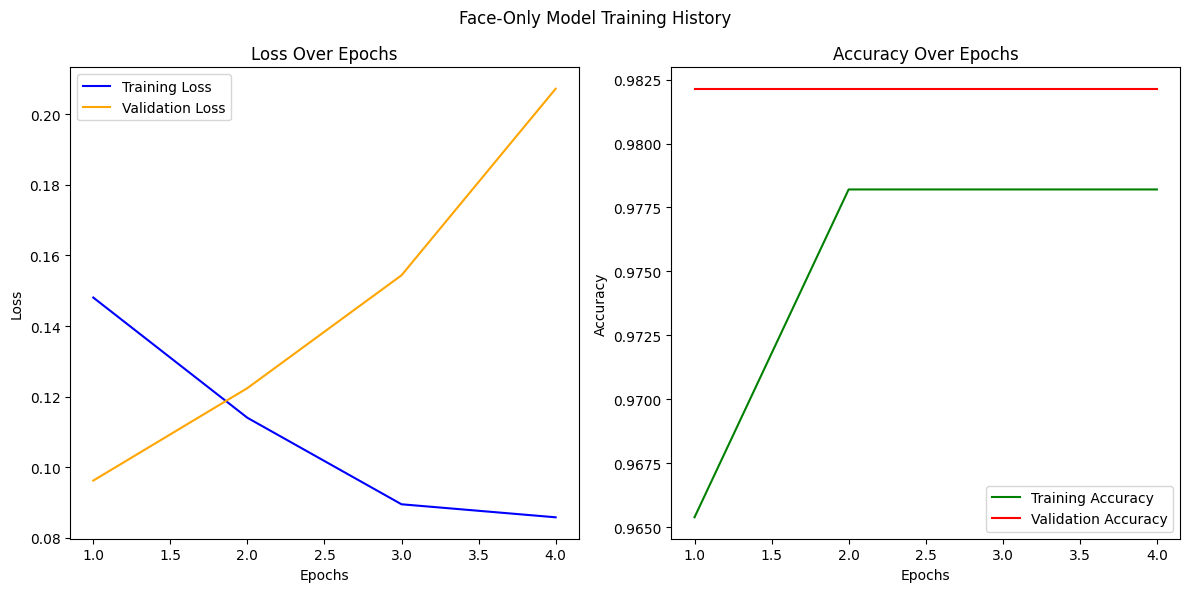

Epoch 1/4
----------


Training epoch 1/4: 100%|██████████| 49/49 [19:13<00:00, 23.55s/it, loss=0.032, acc=0.976]  

Training Loss: 0.2194 Acc: 0.9756


Validation Loss: 0.0960 Acc: 0.9821
Epoch 2/4
----------


Training epoch 2/4: 100%|██████████| 49/49 [14:39<00:00, 17.95s/it, loss=0.481, acc=0.978]  

Training Loss: 0.2507 Acc: 0.9782


Validation Loss: 0.1121 Acc: 0.9821
Epoch 3/4
----------


Training epoch 3/4: 100%|██████████| 49/49 [14:40<00:00, 17.98s/it, loss=0.00242, acc=0.978]

Training Loss: 0.1224 Acc: 0.9782


Validation Loss: 0.1254 Acc: 0.9821
Epoch 4/4
----------


Training epoch 4/4: 100%|██████████| 49/49 [14:32<00:00, 17.80s/it, loss=0.0508, acc=0.978]  

Training Loss: 0.1232 Acc: 0.9782


Validation Loss: 0.1027 Acc: 0.9821
Best validation accuracy: 0.9821


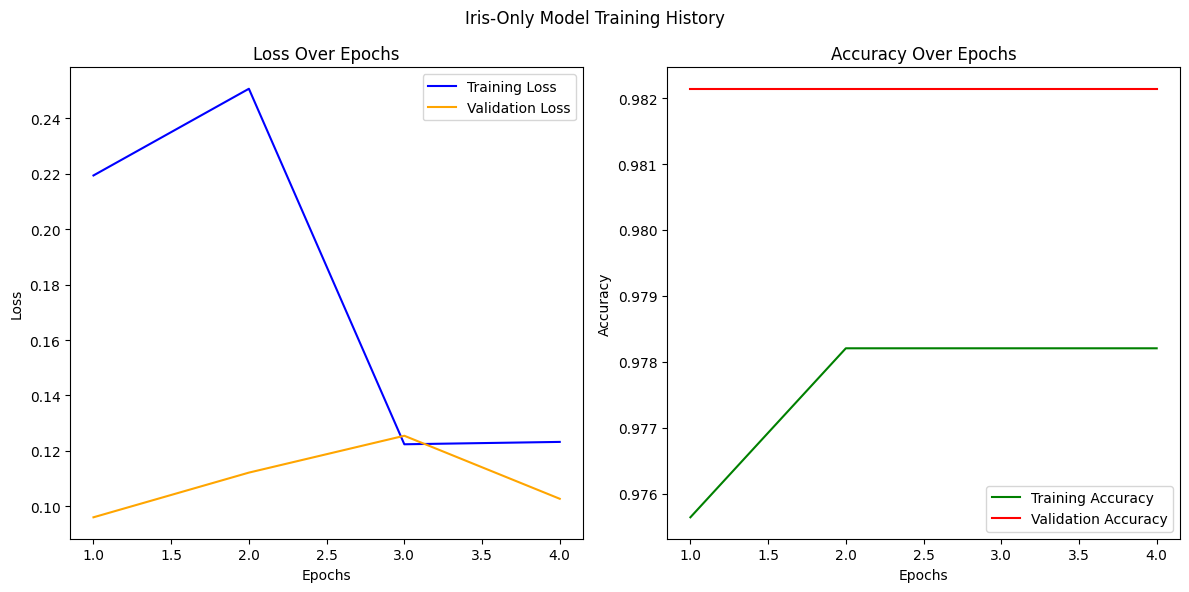

In [17]:
# Train face-only model
history_face = train_model(
    model=face_only_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_face,
    num_epochs=num_epochs,
    device='cpu',
    model_type='face_only'
)

plot_training_history(history_face, title="Face-Only Model Training History")

# Train iris-only model
history_iris = train_model(
    model=iris_only_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_iris,
    num_epochs=num_epochs,
    device='cpu',
    model_type='iris_only'
)

plot_training_history(history_iris, title="Iris-Only Model Training History")


Evaluating: 100%|██████████| 14/14 [01:47<00:00,  7.70s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.1471 Acc: 0.9777
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.98      1.00      0.99       219

    accuracy                           0.98       224
   macro avg       0.49      0.50      0.49       224
weighted avg       0.96      0.98      0.97       224



Evaluating: 100%|██████████| 14/14 [00:33<00:00,  2.41s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.1771 Acc: 0.9777
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.98      1.00      0.99       219

    accuracy                           0.98       224
   macro avg       0.49      0.50      0.49       224
weighted avg       0.96      0.98      0.97       224



Evaluating: 100%|██████████| 14/14 [01:23<00:00,  5.96s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.1105 Acc: 0.9777
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.98      1.00      0.99       219

    accuracy                           0.98       224
   macro avg       0.49      0.50      0.49       224
weighted avg       0.96      0.98      0.97       224



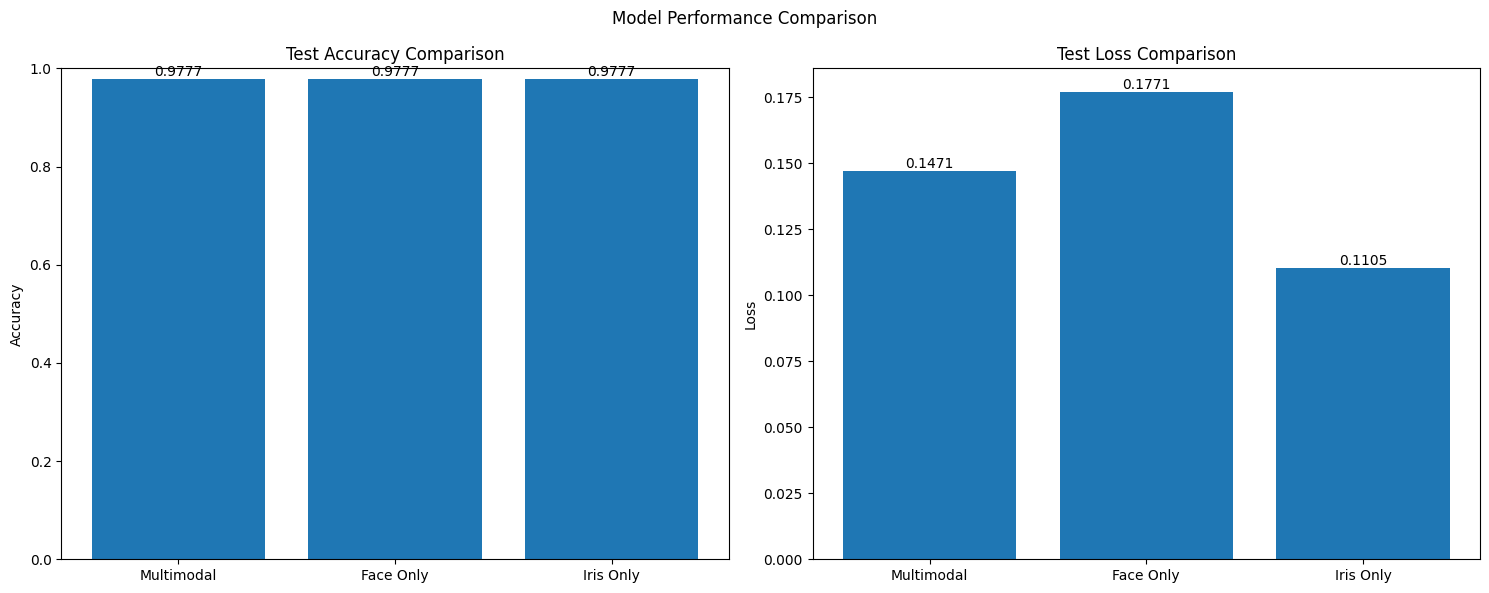

In [19]:
# Evaluate multimodal model
results_multimodal = evaluate_model(
    model=multimodal_model,
    test_loader=test_loader,
    criterion=criterion,
    device='cpu',
    model_type='multimodal'
)

# Evaluate face-only model
results_face = evaluate_model(
    model=face_only_model,
    test_loader=test_loader,
    criterion=criterion,
    device='cpu',
    model_type='face_only'
)

# Evaluate iris-only model
results_iris = evaluate_model(
    model=iris_only_model,
    test_loader=test_loader,
    criterion=criterion,
    device='cpu',
    model_type='iris_only'
)

# Compare results
results_comparison = {
    'Multimodal': results_multimodal,
    'Face Only': results_face,
    'Iris Only': results_iris
}
def compare_models(results, title='Model Performance Comparison'):
    """Compare model performance using key metrics"""
    metrics = ['accuracy', 'loss']
    models = list(results.keys())
    
    plt.figure(figsize=(15, 6))
    
    # Accuracy comparison
    plt.subplot(1, 2, 1)
    accuracies = [results[model]['accuracy'] for model in models]
    bars = plt.bar(models, accuracies)
    plt.title('Test Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom')
    
    # Loss comparison
    plt.subplot(1, 2, 2)
    losses = [results[model]['loss'] for model in models]
    bars = plt.bar(models, losses)
    plt.title('Test Loss Comparison')
    plt.ylabel('Loss')
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, class_names=None, title='Confusion Matrix'):
    """Plot confusion matrix using seaborn"""
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

compare_models(results_comparison, title="Model Performance Comparison")


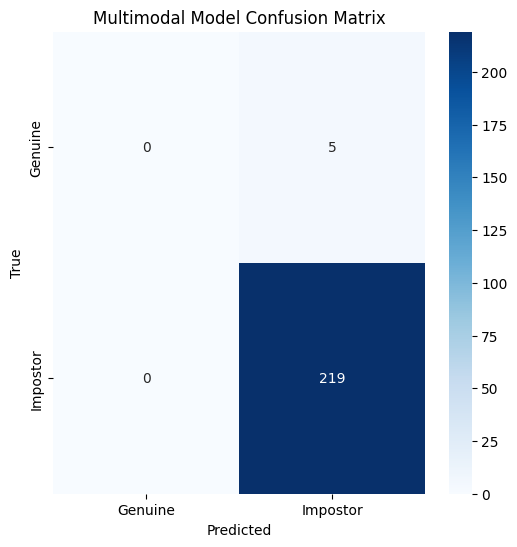

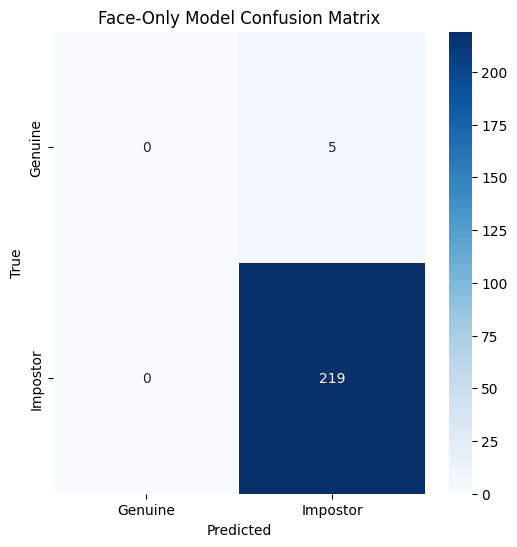

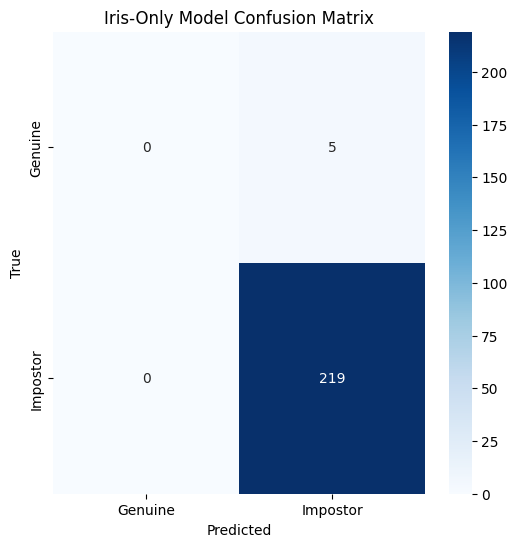

In [20]:
# Visualize confusion matrices for each model
plot_confusion_matrix(results_multimodal['confusion_matrix'], class_names=['Genuine', 'Impostor'], title="Multimodal Model Confusion Matrix")
plot_confusion_matrix(results_face['confusion_matrix'], class_names=['Genuine', 'Impostor'], title="Face-Only Model Confusion Matrix")
plot_confusion_matrix(results_iris['confusion_matrix'], class_names=['Genuine', 'Impostor'], title="Iris-Only Model Confusion Matrix")


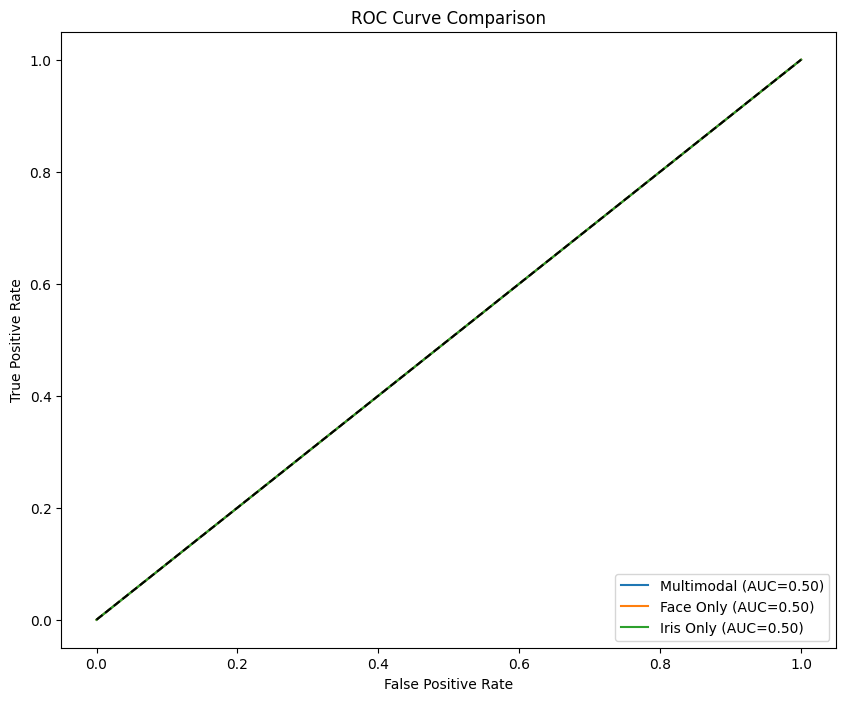

In [21]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(results, title="ROC Curve Comparison"):
    plt.figure(figsize=(10, 8))
    
    for label, result in results.items():
        fpr, tpr, _ = roc_curve(result['labels'], result['predictions'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    
plot_roc_curve(results_comparison)
